# Import Packages

In [2]:
%env MUJOCO_GL = egl
%matplotlib widget
import os
import pickle
from multiprocessing import Lock, Pool
from xml.etree import ElementTree as et

import matplotlib.pyplot as plt
import mediapy as media
import numpy as np

# Access to enums and MuJoCo library functions.
from dm_control import mujoco
from dm_control.mujoco.wrapper.mjbindings import mjlib
from dm_control.utils import inverse_kinematics as ik
from IPython.display import HTML, clear_output, display
from PIL import Image
from scipy.special import gamma

# Rendering parameters
dpi = 100
framerate = 30  # (Hz)
width, height = 1280, 720

# IK solver parameters
_MAX_STEPS = 100
_TOL = 1e-12

# Scene XML
robot_xml = "../models/panda_nohand.xml"
scene_xml = "../models/scene.xml"
site_name = "attachment_site"
reach_sites = ["sharp_site", "round_site", "wedge_site"]
actuator_id = {"sharp_site": 1, "round_site": 2, "wedge_site": 3}
joint_names = ["joint{}".format(i + 1) for i in range(7)]

# Multiprocessing lock
threaded = False
if threaded:
    lock = Lock()

env: MUJOCO_GL=egl


# Update The Scene XML File
* [Mujoco XML Reference](https://mujoco.readthedocs.io/en/latest/XMLreference.html?highlight=site#body-site)
* [The ElementTree XML API](https://docs.python.org/3/library/xml.etree.elementtree.html)

## Tactile Sensor

1. Sensor Pad 
* for visual only

2. Collision Balls (mono-layer)
* _M: (x-count, y-count)
* geom_type: [sphere, capsule, ellipsoid, cylinder, box], “sphere”
* dx: the distance between each site
* offset: uniform distance to shift all sites

3. Slide Joints
* connect the balls to the pad
* joint positions serve as sensory values
* small time constant

4. Tendons to Connect Balls
* planar spring connection
* creates contact-force distribution

## Key Frames
* Initial poses

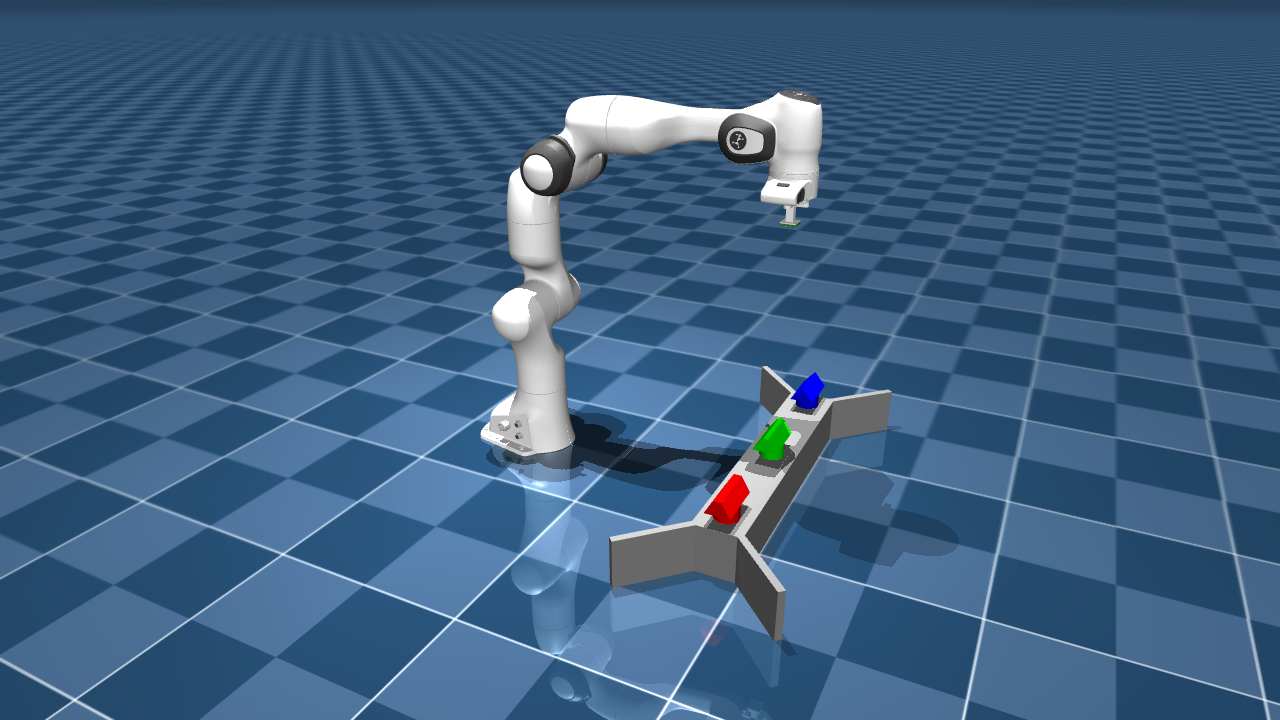

In [3]:
def reset(parent, child_name):
    child = parent.find(child_name)
    if child is not None:
        parent.remove(child)
    return et.SubElement(parent, child_name)


def create_element(name, attrs: dict):
    elem = et.Element(name)
    for k, v in attrs.items():
        if not isinstance(v, str):
            v = str(v)
        elem.set(k, v)
    return elem


# Define 3D arrays of balls connected with sliders
_M = (15, 15)
radius = 5e-4
mass = 1e-6 / np.prod(_M)
dx = (3e-2 - 2 * radius) / (_M[0] - 1)
offset = dx * (_M[0] - 1) / 2.0
geom_type = "sphere"

tree = et.parse(robot_xml)
root = tree.getroot()
for body in root.findall(".//body"):
    if body.get("name") == "sensor_pad":
        sensor_body = body
        for e in body.findall("body"):
            body.remove(e)

tendons = reset(root, "tendon")
sensors = reset(root, "sensor")


def create_composite(sid, pos, euler, springdamper=(2, 1)):
    body = create_element(
        "body",
        {
            "name": "taxel{:d}".format(sid),
            "pos": "{:.6f} {:.6f} {:.6f}".format(pos[0], pos[1], pos[2]),
            "euler": euler,
        },
    )
    inertia = create_element(
        "inertial",
        {
            "mass": "{:.6e}".format(mass),
            "fullinertia": "{} {} {} 0 0 0".format(mass, mass, mass),
            "pos": "0 0 0",
        },
    )
    ballJoint = create_element(
        "joint",
        {
            "name": "ball_joint{}".format(sid),
            "type": "ball",
            "pos": "0 0 2e-3",
            "range": "0 3.14159265",
            "group": 0,
        },
    )
    slideJoint = create_element(
        "joint",
        {
            "name": "slide_joint{}".format(sid),
            "type": "slide",
            "axis": "0 0 1",
            "springdamper": "{} {}".format(springdamper[0], springdamper[1]),
            "frictionloss": "1e-12",
            "group": 1,
        },
    )
    geom = create_element(
        "geom",
        {
            "name": "ball{:d}".format(sid),
            "type": geom_type,
            "size": radius,
            "class": "collision",
            "group": 3,
        },
    )
    site = create_element(
        "site",
        {
            "name": "touch_site{}".format(sid),
            "type": "capsule",
            "size": "{} {}".format(radius, 2 * radius),
            "group": 1,
        },
    )

    body.append(inertia)
    # body.append(ballJoint)
    body.append(slideJoint)
    body.append(geom)
    body.append(site)
    return body


# Define balls with sliders and touch sensors
sid = 0
for i in range(_M[0]):
    for j in range(_M[1]):
        sid += 1
        parent = create_composite(
            sid, (dx * i - offset, dx * j - offset, 1e-3), "0 0 0", (2e-3, 0.9)
        )
        sensor_body.append(parent)
        touch_sensor = et.SubElement(
            sensors, "touch".format(sid), {"site": "touch_site{}".format(sid)}
        )

tree.write(robot_xml)  # Save robot XML

# Modify the keyframe home key qpos
njoints = np.prod(_M) + 10
tree = et.parse(scene_xml)
root = tree.getroot()
key = root.find(".//keyframe/key")
qpos_value = "0 0 0 {} 0 {} 0.785398 0 0 0".format(
    -0.5 * np.pi, 0.5 * np.pi, 0.25 * np.pi
)
key.attrib["ctrl"] = qpos_value
if njoints > 10:
    qpos_value += " " + " ".join(["0" for i in range(njoints - 10)])
key.attrib["qpos"] = qpos_value
tree.write(scene_xml)

# XML testing
physics = mujoco.Physics.from_xml_path(scene_xml)
physics.reset(0)
pixels = physics.render(camera_id="prospective", width=width, height=height)
Image.fromarray(pixels)

# Robotic Simulation for Tactile Encoding Test

* Synthetic data generation
    - Check [models](../models/platform.xml) for edge types
* Save sensor data and simulation
    - [Sensordata](touch3edge.pkl)

In [4]:
def gen_dataset(
    scene_xml, site_name, target_name, joint_names, duration=2.0, rendered=True
):
    physics = mujoco.Physics.from_xml_path(scene_xml)
    physics.reset(0)

    omega = 4 * np.pi / duration * np.array([1, 1, 1])
    ctrl = np.empty(10)
    video = []
    stream = []
    orientations = []
    control_site = physics.data.site(name=site_name)
    target_site = physics.data.site(name=target_name)
    target_quat = mat2quat(control_site.xmat)
    target_xpos = target_site.xpos.copy()
    target_xpos[2] -= 1e-3
    smooth_factor = 0.5

    # Simulate, saving video frames
    while physics.data.time <= duration:
        move_vec = (
            (target_xpos - control_site.xpos)
            * min(smooth_factor, physics.data.time)
            / smooth_factor
        )
        # Compute the inverse kinematics
        if np.linalg.norm(control_site.xpos - target_xpos) > _TOL:
            result = ik.qpos_from_site_pose(
                physics,
                site_name,
                target_pos=control_site.xpos + move_vec,
                target_quat=target_quat,
                joint_names=joint_names,
                tol=_TOL,
                max_steps=_MAX_STEPS,
                inplace=False,
            )
            ctrl[:7] = result.qpos[:7]
        ctrl[-3:] = omega * physics.data.time
        physics.set_control(ctrl)
        physics.step()

        # Save sensordata when there is contact
        if len(physics.data.contact) > 0:
            sensordata = physics.data.sensordata.copy()
            M = np.sqrt(sensordata.shape[0]).astype(int)
            data = sensordata.reshape(M, M)
            stream.append(data)
            oris = physics.named.data.qpos[
                "rotator_joint%d" % actuator_id[target_name]
            ].copy()
            orientations.append(oris)

        # Save video frames
        clear_output(wait=True)
        print(
            "PID {} simulating {}. Progress: {:.1f}%".format(
                os.getpid(), target_name, physics.data.time / duration * 100
            )
        )
        if rendered and len(video) < physics.data.time * framerate:
            if threaded:
                lock.acquire()
            pixels = physics.render(camera_id="prospective", width=width, height=height)
            if threaded:
                lock.release()
            video.append(pixels.copy())

    return target_name, video, stream, orientations


ds = dict()

for rs in reach_sites:
    label, video, stream, orientations = gen_dataset(
        scene_xml, site_name, rs, joint_names, duration=7.0, rendered=True
    )
    ds[label] = {"sensordata": stream, "orientations": orientations}
    media.write_video("../data/" + label + ".mp4", video, fps=30)

with open("../data/touch.pkl", "wb") as f:
    pickle.dump(ds, f)


PID 60402 simulating wedge_site. Progress: 100.0%
